In [1]:
## imports ###

import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer

import sys
sys.path.append('../')

from models.lvae import LadderVAE
from boilerplate import boilerplate
import lib.utils as utils
import training

import os
import glob
import zipfile
import urllib
from tifffile import imread, imsave
from matplotlib import pyplot as plt
from tqdm import tqdm

from pathlib import Path
import cv2
from MyScripts.crop_center import crop_center

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [3]:
# parameters


# Model 
modelName = "Vim_mtlplSNR_Noise1_GMM1N2V_ConvTransposeBefore_Upsamp2_Clip-3_Lat32x5_5Blocks_betaKL0.001_NoAugment"
modelPath = Path("./Trained_model/model/") / (modelName + "_best_vae.net")

# Data
basedir = Path(r"/group/jug/Anirban/Datasets/scilife_data")
data_path_signal = basedir / "test_data" / "avg_and_n2v"
data_path_obs = basedir /  "test_data" / "mltpl_snr_stacks"

# Normalization values
mean_value = 32.78586959838867
std_value = 70.50637817382812 

# Data parameters
upsamp = 2
upsamp_beforeNN = False # put True to re-upsample with nearest neighbor before feeding in neural net
DataNoiseLvl = [1] # "all", int, or list of int
clip = -3

if not upsamp_beforeNN:
    crop_coeff = upsamp
else:
    crop_coeff = 1

# Inference parameters
crop_size = 64 # NOTE: crop size in "output space" after upsampling, so it should be a multiple of upsampling factor
tiling = True # to predict whole image with tiling
tilingMargin = 16 # tilingMargin added to crop_size to avoid edge effect when tiling

num_samples = 50 # number of samples used to compute MMSE estimate
tta = False

# Saving prm
saving = True
save_suffix = ""
save_folder = basedir / "inference" / (modelName + f"_{save_suffix}")
overwrite = True

save_samples = True
save_mmse = True
save_std = False
save_var = False

if saving:
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    else:
        assert overwrite == True, "Saving folder already exists. Set overwrite = True to enable overwriting inference folder"


In [4]:
# Load data

##### Load data ####

signal = []
observation = []
filters = ['tif','tiff']

files_signal = os.listdir(data_path_signal)
files_obs = os.listdir(data_path_obs)
files_signal.sort()
files_obs.sort()

for f in files_signal:
    if f.split('.')[-1] not in filters:
        print(f"removing {f} in signals because not in filters")
        files_signal.remove(f)

for f in files_obs:
    if f.split('.')[-1] not in filters:
        print(f"Removing {f} in observations because not in filters")
        files_obs.remove(f)

assert len(files_obs) == len(files_signal)
n_images= len(files_obs)
print(f"\nFound {n_images} images.\n")

if isinstance(DataNoiseLvl,list) or DataNoiseLvl == "all":
    mltplNoise = True
else:
    mltplNoise = False
    nNoise = 1

for i in range (len(files_obs)):
    file_signal = files_signal [i]
    file_obs = files_obs [i]
    im_signal = imread(data_path_signal / file_signal)[0]
    
    # noise level selection
    if DataNoiseLvl == "all":
        im_obs  = imread(data_path_obs / file_obs)[:5]
    elif isinstance(DataNoiseLvl,int) or isinstance(DataNoiseLvl,list):
        try:
            im_obs = imread(data_path_obs / file_obs)[DataNoiseLvl]
        except IndexError:
            continue

    if not isinstance(clip,bool):
        im_obs[im_obs<clip] = 0
        im_signal[im_signal<clip] = 0


    observation.append(im_obs)
    signal.append(im_signal)

    print(f"Signal {file_signal}:\tObservation {file_obs}:\t Shape: {im_obs.shape}")

# Stack to numpy array
signal = np.stack(signal)
observation = np.stack(observation)

# Adjust array dimension if necessary
if mltplNoise:
    nNoise = observation.shape[1]
    nrepeat = observation.shape[1]
    observation = np.reshape(observation,(observation.shape[0]*observation.shape[1],observation.shape[2],observation.shape[3]))    
    signal = np.repeat(signal,nrepeat,axis=0)

# square crop (like in training)
if signal.shape[-1] != signal.shape[-2]:
    print("Cropping to square")
    img_size = min(signal.shape[-1],signal.shape[-2])
    signal = crop_center(signal,img_size)
    observation = crop_center(observation,img_size)

#if tiling, we crop so that img size is a multiple of crop_size
if tiling and img_size%crop_size!=0:
    img_size = img_size - img_size%crop_size
    signal = crop_center(signal,img_size)
    observation = crop_center(observation,img_size)

# Normalization
signal = (signal - (mean_value))/(std_value) 
observation = (observation - (mean_value))/(std_value)

# downsampling input
if upsamp>1:
    observation2 = []
    for im in observation:
        dwnsamp=im[::upsamp,::upsamp]
        if upsamp_beforeNN:
            interp=cv2.resize(dwnsamp, None, fx=upsamp, fy=upsamp, interpolation= cv2.INTER_CUBIC)
            observation2.append(interp)
        else:
            observation2.append(dwnsamp)
    observation = np.stack(observation2)

print(f"\n\nConcatenated arrays and cropped:\tSignal: {signal.shape}\tObservation: {observation.shape}")




Found 2 images.

Signal img_and_denoised_00.tiff:	Observation rec_c01_rec_CAM.tiff:	 Shape: (1, 1416, 1392)
Signal img_and_denoised_01.tiff:	Observation rec_c02_rec_CAM.tiff:	 Shape: (1, 1416, 1392)
Cropping to square


Concatenated arrays and cropped:	Signal: (2, 1344, 1344)	Observation: (2, 672, 672)


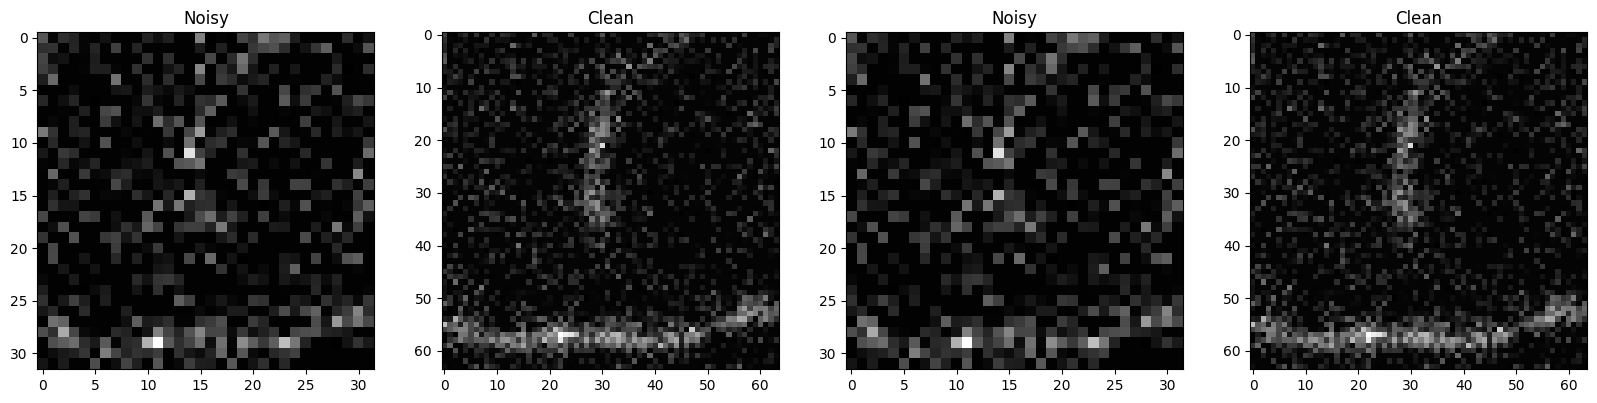

In [5]:
# Display examples

idxs = np.random.randint(0,observation.shape[0],2)

plt.figure(figsize=(20,10))
plt.subplot(1,4,1)
plt.imshow(crop_center(observation[idxs[0]],crop_size//crop_coeff),cmap="gray")
plt.title("Noisy")

plt.subplot(1,4,2)
plt.imshow(crop_center(signal[idxs[0]],crop_size),cmap="gray")
plt.title("Clean")

plt.subplot(1,4,3)
plt.imshow(crop_center(observation[idxs[1]],crop_size//crop_coeff),cmap="gray")
plt.title("Noisy")

plt.subplot(1,4,4)
plt.imshow(crop_center(signal[idxs[1]],crop_size),cmap="gray")
plt.title("Clean")

plt.show()

In [6]:
# inference 

model = torch.load(modelPath)
model.mode_pred=True
model.eval()

gaussian_noise_std = None
img_mmse_list = []
samples_list = []
tiling = False
# simple inference
if not tiling:
    signal = crop_center(signal,crop_size)
    observation = crop_center(observation,crop_size//crop_coeff)
    for i in range (n_images):
        for noise in range (nNoise):
            input = observation[i*nNoise+noise]
            img_mmse, samples = boilerplate.predict(input,num_samples,model,gaussian_noise_std,device,tta)
            img_mmse_list.append(img_mmse)
            samples_list.append(np.stack(samples))


# inference of full image with tiling
else:
    tilingMargin_inp = tilingMargin//crop_coeff
    crop_size_inp = crop_size//crop_coeff
    for i in range (n_images):
        for noise in range (nNoise):
            obs = np.pad(observation[i*nNoise+noise],(tilingMargin_inp,tilingMargin_inp))
            img_mmse = np.zeros([img_size,img_size],dtype='float32')
            samples = np.zeros([num_samples,img_size,img_size])
            for y in range(tilingMargin,img_size-tilingMargin,crop_size):
                for x in range(tilingMargin,img_size-tilingMargin,crop_size):
                    x1 = x//crop_coeff-tilingMargin_inp
                    y1 = y//crop_coeff-tilingMargin_inp
                    x2 = x//crop_coeff + crop_size_inp + tilingMargin_inp
                    y2 = y//crop_coeff + crop_size_inp + tilingMargin_inp
                    # img_mmse_crop, samples_crop = boilerplate.predict(obs[y:y+crop_size_inp,x:x+crop_size_inp],num_samples,model,gaussian_noise_std,device,tta)
                    img_mmse_crop, samples_crop = boilerplate.predict(obs[y1:y2,x1:x2],num_samples,model,gaussian_noise_std,device,tta)

                    img_mmse[y-tilingMargin:y+crop_size-tilingMargin,x-tilingMargin:x+crop_size-tilingMargin] = img_mmse_crop[tilingMargin:-tilingMargin,tilingMargin:-tilingMargin]
                    samples[:,y-tilingMargin:y+crop_size-tilingMargin,x-tilingMargin:x+crop_size-tilingMargin] = np.stack(samples_crop,axis=0)[:,tilingMargin:-tilingMargin,tilingMargin:-tilingMargin]


            img_mmse_list.append(img_mmse)
            samples_list.append(np.stack(samples))        

100%|██████████| 50/50 [00:01<00:00, 27.54it/s]


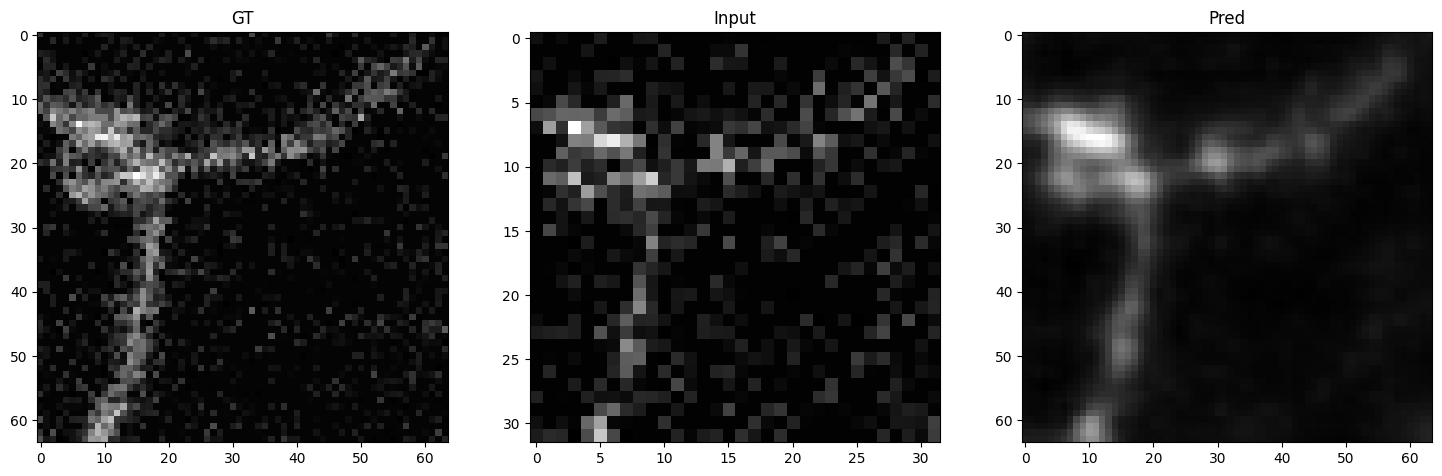

In [7]:
#display

idx=0
colormap = "gray"

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(signal[idx],cmap = colormap)
plt.title("GT")
plt.subplot(1,3,2)
plt.imshow(observation[idx],cmap = colormap)
plt.title("Input")
plt.subplot(1,3,3)
plt.imshow(img_mmse_list[idx],cmap = colormap)
plt.title("Pred")

# also show smaller region crop if tiling
if tiling:
    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1)
    plt.imshow(crop_center(signal[idx],crop_size),cmap = colormap)
    plt.title("GT")
    plt.subplot(1,3,2)
    plt.imshow(crop_center(observation[idx],crop_size//crop_coeff),cmap = colormap)
    plt.title("Input")
    plt.subplot(1,3,3)
    plt.imshow(crop_center(img_mmse_list[idx],crop_size),cmap = colormap)
    plt.title("Pred")

plt.show()

In [8]:
# Saving:
#   - if single noise level, results are saved as a stack: gt-inp-mmse (and samples in a different file)
#   - if mltpl noise level, results of all noise are saved as a single stack: gt first, then [inp-mmse] pair for each noise level (samples saved separetly for each noise level)
#   - NOTE: if input not upsampled before net, it is upsample with nearest neighbor to match gt and pred size


# single noise level
if saving and not mltplNoise:
    for i in range(observation.shape[0]):
        if not upsamp_beforeNN:
            input = cv2.resize(observation[i],None,fx=upsamp, fy=upsamp, interpolation= cv2.INTER_NEAREST)
        else:
            input = observation[i]
        summary = np.stack([signal[i],input,img_mmse_list[i]],axis=0)
        samples = samples_list[i]
        std = np.std(samples,axis=0)
        var = np.var(samples,axis=0)
        if save_mmse:
            imsave(save_folder / f"gt_inp_mmse{num_samples}_Noise{DataNoiseLvl}_{i:02d}.tif",summary,imagej=True,metadata={'axes':'TYX'})
        if save_samples:
            imsave(save_folder / f"samples_{i:02d}_Noise{DataNoiseLvl}_.tif",samples)
        if save_std:
            imsave(save_folder / f"std_{i:02d}_Noise{DataNoiseLvl}_.tif",std)
        if save_var:
            imsave(save_folder / f"var_{i:02d}_Noise{DataNoiseLvl}_.tif",var)   


# multiple noise level
elif saving and mltplNoise:
    for i in range(n_images):
        summary = [signal[i*nNoise]] 
        for noise in range(nNoise):
            if not upsamp_beforeNN:
                input = cv2.resize(observation[i*nNoise+noise],None,fx=upsamp, fy=upsamp, interpolation= cv2.INTER_NEAREST)
            else:
                input = observation[i*nNoise+noise]
            summary.append(input)
            summary.append(img_mmse_list[i*nNoise+noise])
            samples = samples_list[i*nNoise+noise] 
            std = np.std(samples,axis=0)
            std_norm = std / img_mmse_list[i*nNoise+noise]
            var = np.var(samples,axis=0)
            var_norm = var / img_mmse_list[i*nNoise+noise]
            if save_samples:
                imsave(save_folder / f"samples_{i:02d}_Noise{noise}_{i:02d}.tif",samples)
            if save_std:
                imsave(save_folder / f"std_{i:02d}_Noise{noise}_{i:02d}.tif",std)
                imsave(save_folder / f"std_norm{i:02d}_Noise{noise}_{i:02d}.tif",std_norm)
            if save_var:
                imsave(save_folder / f"var_{i:02d}_Noise{noise}_{i:02d}.tif",var)
                imsave(save_folder / f"var_norm{i:02d}_Noise{noise}_{i:02d}.tif",var_norm)
        
        summary=np.stack(summary,axis=0)

        if save_mmse:
            if isinstance(DataNoiseLvl,list):
                noise_level_str = ''.join(str(DataNoiseLvl).split(', '))[1:-1]
            else:
                noise_level_str = DataNoiseLvl
            imsave(save_folder / f"gt_inp_mmse{num_samples}_Noise{noise_level_str}_{i:02d}.tif",summary,imagej=True,metadata={'axes':'TYX'})

/tmp/ipykernel_55408/4005042053.py:45: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave(save_folder / f"samples_{i:02d}_Noise{noise}_{i:02d}.tif",samples)
/tmp/ipykernel_55408/4005042053.py:60: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave(save_folder / f"gt_inp_mmse{num_samples}_Noise{noise_level_str}_{i:02d}.tif",summary,imagej=True,metadata={'axes':'TYX'})
